# Procesado de datos


En esta notebook vamos a ver cómo podemos procesar datos satelitales dentro de SPAI. Como está basado en Python, podemos utilizar e integrar diferentes librerías de terceros, como `geopandas` o `xarray`, juntamente con diferentes funciones de SPAI que nos ayudan a simplificar procesos.

Para este caso de uso práctico, vamos a hacer un análisis de calidad del agua en el Estany d'Ivars, en Catalunya, España. Utilizaremos índices espectrales específicos para evaluar diferentes aspectos de la calidad del agua.


## Índices espectrales


![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41597-023-02096-0/MediaObjects/41597_2023_2096_Fig6_HTML.png)


Los índices espectrales son combinaciones de diferentes bandas del espectro electromagnético que se utilizan para resaltar ciertas características de la superficie terrestre. Estos índices son útiles para aplicaciones como la monitorización de la vegetación, la evaluación de la calidad del agua, la detección de cambios en el uso del suelo, entre otros.

Para el análisis de calidad del agua, utilizaremos dos índices espectrales comunes: el Índice Diferencial de Agua Normalizado (NDWI) y el Índice Diferencial de Clorofila Normalizado (NDCI).


Sin más, ¡comenzamos! Lo primero que haremos es declarar nuestro `Storage` y nuestra `aoi`.


In [50]:
from spai.data.satellite import load_satellite_imagery
from spai.storage import Storage
import os

os.environ["SPAI_STORAGE_NAMES"] = "local_data"
os.environ["SPAI_STORAGE_LOCAL_PATH"] = "./data"

storage = Storage()["data"]

gdf = storage.read("estany_ivars.geojson")

'data' folder ready to use


Vamos a centrar el análisis en las fechas del mes de julio del 2023.

> ¡Importante! Filtramos por cobertura de nubes.


In [51]:
data = load_satellite_imagery(
    gdf, ("2023-07-01", "2023-07-31"), collection="sentinel-2-l2a", cloud_cover=20
)
# TODO coger solo las fechas que nos importan
print(f"N´umero de imágenes: {len(data.time.values)}")
data

N´umero de imágenes: 4


<xarray.Dataset> Size: 7MB
Dimensions:      (latitude: 169, longitude: 402, time: 4)
Coordinates:
  * latitude     (latitude) float64 1kB 41.69 41.69 41.69 ... 41.68 41.67 41.67
  * longitude    (longitude) float64 3kB 0.9299 0.93 0.93 ... 0.9659 0.966
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 32B 2023-07-09T10:59:32.364000 ... 202...
Data variables:
    coastal      (time, latitude, longitude) uint16 544kB dask.array<chunksize=(4, 169, 402), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 544kB dask.array<chunksize=(4, 169, 402), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 544kB dask.array<chunksize=(4, 169, 402), meta=np.ndarray>
    red          (time, latitude, longitude) uint16 544kB dask.array<chunksize=(4, 169, 402), meta=np.ndarray>
    rededge1     (time, latitude, longitude) uint16 544kB dask.array<chunksize=(4, 169, 402), meta=np.ndarray>
    rededge2     (time, latitude, longitude) uint16 544kB dask.array<chunksize=(4, 169, 402), meta=np.ndarray>
    rededge3     (time, latitude, longitude) uint16 544kB dask.array<chunksize=(4, 169, 402), meta=np.ndarray>
    nir          (time, latitude, longitude) uint16 544kB dask.array<chunksize=(4, 169, 402), meta=np.ndarray>
    nir08        (time, latitude, longitude) uint16 544kB dask.array<chunksize=(4, 169, 402), meta=np.ndarray>
    nir09        (time, latitude, longitude) uint16 544kB dask.array<chunksize=(4, 169, 402), meta=np.ndarray>
    swir16       (time, latitude, longitude) uint16 544kB dask.array<chunksize=(4, 169, 402), meta=np.ndarray>
    swir22       (time, latitude, longitude) uint16 544kB dask.array<chunksize=(4, 169, 402), meta=np.ndarray>

Para este taller, vamos a coger sólo la primera fecha. Para que sea más rápido, vamos a computar los datos. Eso quiere decir que los guardamos en disco para que los procesos sean más rápidos.


In [52]:
data = data.isel(time=0)
data.compute()

<xarray.Dataset> Size: 2MB
Dimensions:      (latitude: 169, longitude: 402)
Coordinates:
  * latitude     (latitude) float64 1kB 41.69 41.69 41.69 ... 41.68 41.67 41.67
  * longitude    (longitude) float64 3kB 0.9299 0.93 0.93 ... 0.9659 0.966
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2023-07-09T10:59:32.364000
Data variables:
    coastal      (latitude, longitude) uint16 136kB 655 655 655 ... 286 286 286
    blue         (latitude, longitude) uint16 136kB 1394 1394 1412 ... 238 238
    green        (latitude, longitude) uint16 136kB 1898 1898 1894 ... 390 390
    red          (latitude, longitude) uint16 136kB 2476 2476 2448 ... 314 314
    rededge1     (latitude, longitude) uint16 136kB 2717 2717 2717 ... 715 715
    rededge2     (latitude, longitude) uint16 136kB 3049 3049 3049 ... 1499 1499
    rededge3     (latitude, longitude) uint16 136kB 3348 3348 3348 ... 1854 1854
    nir          (latitude, longitude) uint16 136kB 3412 3412 3344 ... 1924 1924
    nir08        (latitude, longitude) uint16 136kB 3592 3592 3592 ... 2104 2104
    nir09        (latitude, longitude) uint16 136kB 3782 3782 3782 ... 2629 2629
    swir16       (latitude, longitude) uint16 136kB 4293 4293 4293 ... 1760 1760
    swir22       (latitude, longitude) uint16 136kB 3561 3561 3561 ... 1107 1107

### NDWI


Para calcular la superfície de agua vamos a calcular el NDWI. El NDWI es un índice espectral utilizado para detectar la presencia de agua en cuerpos de agua superficiales. Se calcula utilizando las bandas del espectro infrarrojo cercano (NIR) y del espectro verde. La fórmula para calcular el NDWI es la siguiente:

Meter aqui la imagen!!!!!!!!!!!!!!!!!!!

<div style="text-align:center;">
    <img src="https://custom-images.strikinglycdn.com/res/hrscywv4p/image/upload/c_limit,fl_lossy,h_9000,w_1200,f_auto,q_auto/5800260/153872_320172.png" alt="image" />
</div>


Para normalizar los datos, y también eliminar outliers, lo dividimos entre 3000.


In [53]:
green = data.green / 3000
nir = data.nir / 3000
ndwi = (green - nir) / (green + nir)
ndwi

<xarray.DataArray (latitude: 169, longitude: 402)> Size: 544kB
dask.array<truediv, shape=(169, 402), dtype=float64, chunksize=(169, 402), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 1kB 41.69 41.69 41.69 ... 41.68 41.67 41.67
  * longitude    (longitude) float64 3kB 0.9299 0.93 0.93 ... 0.9659 0.966
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2023-07-09T10:59:32.364000

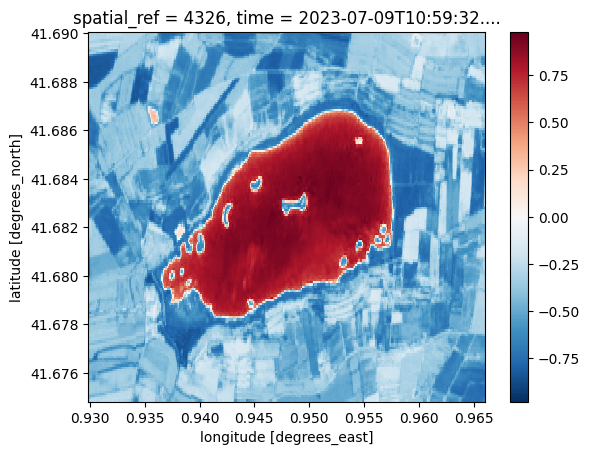

In [54]:
ndwi.plot()

## Water mask


Los valores de las masas de agua son superiores a 0.2, mientras que la vegetación tiene valores mucho más pequeños, lo que permite distinguir más fácilmente la vegetación de estas. Los elementos construidos tienen valores positivos entre cero y 0,2.

Los valores del NDWI corresponden a los siguientes rangos:

- 0,2 – 1 – Superficie del agua,
- 0,0 – 0,2 – Inundación, humedad,
- -0,3 – 0,0 – Sequía moderada, superficies sin agua,
- -1 – -0,3 – Sequía, superficies sin agua


In [55]:
water_mask = ndwi.where((ndwi >= 0.2) & (ndwi <= 1))
water_mask

<xarray.DataArray (latitude: 169, longitude: 402)> Size: 544kB
dask.array<where, shape=(169, 402), dtype=float64, chunksize=(169, 402), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 1kB 41.69 41.69 41.69 ... 41.68 41.67 41.67
  * longitude    (longitude) float64 3kB 0.9299 0.93 0.93 ... 0.9659 0.966
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2023-07-09T10:59:32.364000

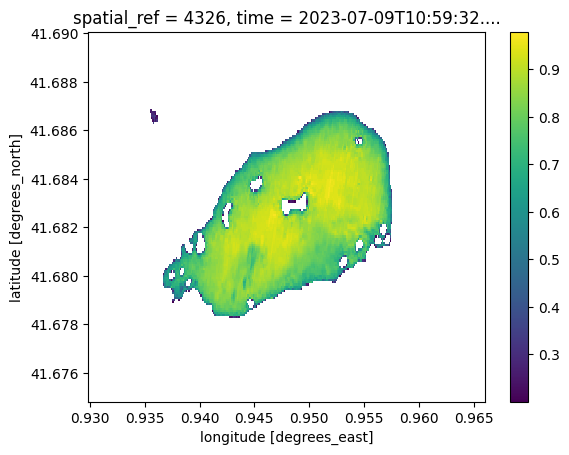

In [56]:
water_mask.plot()

Saquemos la fecha para poder guardar la imagen con la fecha correspondiente.


In [57]:
water_mask.time.values

numpy.datetime64('2023-07-09T10:59:32.364000000')

¡Y la guardamos!


In [58]:
import rioxarray

time = "2023-07-09"
water_mask.rio.to_raster(f"data/water_mask_{time}.tif")

Para mayor comodidad y luego poder contar los píxeles con agua, para sacar la superfície de agua, creamos una máscara binaria con 0 y 1.


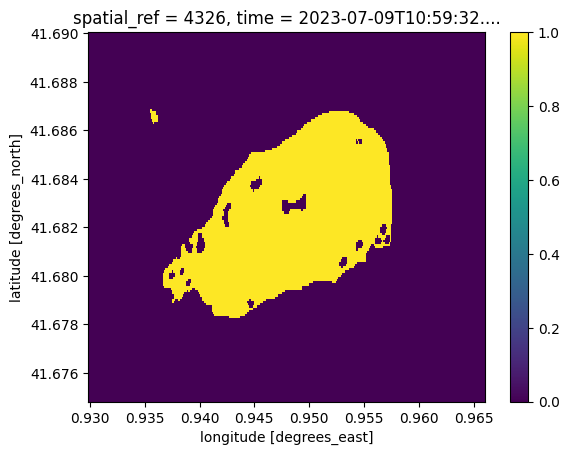

In [59]:
water_mask_binary = water_mask.fillna(0)
water_mask_binary = water_mask_binary.where(water_mask_binary == 0, 1)
water_mask_binary.plot()

Y de nuevo, lo guardamos!


In [60]:
water_mask_binary.rio.to_raster(f"data/water_mask_binary_{time}.tif")

Ahora podemos contar los píxeles. SPAI provee varias funciones para agilizar el proceso, primero para leer directamente el ráster desde el `Storage` y luego, para contar los píxeles según los valores que les demos.


In [ ]:
from spai.processing import read_raster, px_count

ds, raster = read_raster(f"water_mask_binary_{time}.tif", storage)

In [62]:
non_water, water, _ = px_count(raster, [0, 1])
pixel_size = 10  # meters
area = water * (pixel_size / 1000) ** 2  # convert to square kilometers
print(f"Superficie de agua: {area:.2f} km2")

Superficie de agua: 1.28 km2


## NDCI


El NDCI es un índice espectral utilizado para estimar la concentración de clorofila-a en cuerpos de agua, lo cual es un indicador de la presencia de fitoplancton y, por ende, de la calidad del agua. Se calcula utilizando las bandas del espectro rojo y del espectro rojo lejano. La fórmula para calcular el NDCI es la siguiente:

​METER AQUI LA IMAGEN!!!!!!!!!!!!!!!!

Calcular el NDCI es crucial porque la clorofila-a es un pigmento presente en las algas y otras plantas acuáticas, y su concentración puede servir como un indicador de la productividad biológica del agua. Un aumento en los niveles de clorofila-a puede señalar eutrofización, un proceso donde el agua se enriquece con nutrientes, llevando a un crecimiento excesivo de algas que puede afectar negativamente la calidad del agua y los ecosistemas acuáticos.


In [63]:
rededge1 = data.rededge1 / 3000
red = data.red / 3000
ndci = (rededge1 - red) / (rededge1 + red)
ndci

<xarray.DataArray (latitude: 169, longitude: 402)> Size: 544kB
dask.array<truediv, shape=(169, 402), dtype=float64, chunksize=(169, 402), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 1kB 41.69 41.69 41.69 ... 41.68 41.67 41.67
  * longitude    (longitude) float64 3kB 0.9299 0.93 0.93 ... 0.9659 0.966
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2023-07-09T10:59:32.364000

Si bien hemos calculado el NDCI, debemos asegurarnos que lo calculamos solo donde haya agua.


In [64]:
ndci_water = ndci.where(water_mask_binary == 1)
ndci_water

<xarray.DataArray (latitude: 169, longitude: 402)> Size: 544kB
dask.array<where, shape=(169, 402), dtype=float64, chunksize=(169, 402), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 1kB 41.69 41.69 41.69 ... 41.68 41.67 41.67
  * longitude    (longitude) float64 3kB 0.9299 0.93 0.93 ... 0.9659 0.966
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2023-07-09T10:59:32.364000

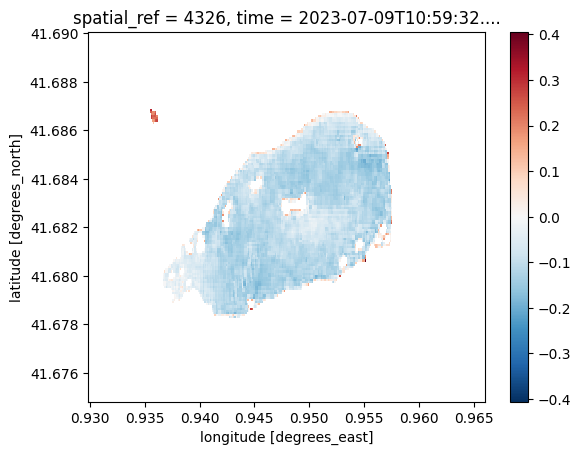

In [65]:
ndci_water.plot()

¡Vamos a guardar nuestro NDCI!


In [66]:
ndci_water.rio.to_raster(f"data/ndci_{time}.tif")

Y ahora que lo hemos guardado, podemos categorizarlo según unos valores estudiados en la literatura que nos dan información sobre la cantidad de algas en el cuerpo de agua.

Los valores de NDCI pueden ser interpretados de la siguiente manera para evaluar la calidad del agua:

- NDCI < 0.1: Baja concentración de clorofila-a, agua generalmente de buena calidad.
- 0.1 ≤ NDCI < 0.3: Moderada concentración de clorofila-a, agua con calidad aceptable pero con presencia de algo de fitoplancton.
- 0.3 ≤ NDCI < 0.5: Alta concentración de clorofila-a, indicando posibles problemas de eutrofización. Se debe monitorear la calidad del agua con mayor frecuencia.
- NDCI ≥ 0.5: Muy alta concentración de clorofila-a, señalando problemas serios de eutrofización. El agua probablemente tiene una calidad pobre y podría necesitar intervención.


In [67]:
import numpy as np

ds, raster = read_raster(f"ndci_{time}.tif", storage)
raster[np.isnan(raster)] = -9999
ndci_categories = np.digitize(raster, [-1, 0.1, 0.3, 0.5, 1])

In [70]:
unique_values = np.unique(ndci_categories)
print(unique_values)

[0 1 2 3]


In [68]:
from spai.processing import colorize_raster

colors = {
    1: "green",
    2: "yellow",
    3: "orange",
    4: "red",
}
ndci_color = colorize_raster(ndci_categories, colors)
storage.create(ndci_color, f"ndci_color_{time}.tif", ds=ds)

'data/ndci_color_2023-07-09.tif'

## ¿Qué sigue?


Con esto, hemos visto como podemos combinar diferentes funciones de SPAI junto con otras libreríar para procesar nuestros datos.

En la siguiente notebook, probaremos un modelo de IA de la API de SPAI y haremos inferencia con él para extraer la red de carreteras de una imagen de satélite. Sin más, vamos a la siguiente [notebook](04_inferencia_ia.ipynb).
